Data Source - 
https://www.census.gov/retail/marts/www/timeseries.html

Sales data are adjusted for seasonal, holiday, and trading-day differences.
So recover the original data by applying the seasonal factors.

In [1]:
import pandas as pd
import numpy as np

df_adjusted = pd.read_excel('Retail and Food Services.xlsx')
df_seasonal = pd.read_excel('Seasonal Factors.xlsx')

In [2]:
df_adjusted.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,164083,164260,163747,164759,165617,166098,167305,167797,169407,170681.0,171025.0,172995.0
1,1993,175078,173770,172328,176766,178445,178201,180759,180692,181800,182910.0,184746.0,186339.0
2,1994,185128,188077,191588,191632,190940,193196,193763,196157,197754,199579.0,199723.0,200670.0
3,1995,201583,198383,200230,201048,202993,205507,204959,206529,206978,206157.0,208661.0,210434.0
4,1996,208731,212011,213855,214644,216304,216059,216374,216355,219240,221039.0,220989.0,221898.0


In [3]:
df1 = pd.melt(df_adjusted, id_vars=['YEAR'], value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'], var_name='MONTH')
df1['ds'] = pd.to_datetime(df1['YEAR'].astype(str) + df1['MONTH'], format='%Y%b')
df1 = df1.drop('YEAR', axis=1)
df1 = df1.drop('MONTH', axis=1)
df1.columns = ['y', 'ds']
df1 = df1[['ds', 'y']]
df1 = df1.sort_values(['ds'], ascending=True)
df1 = df1.reset_index(drop=True)
df1.head()

,ds,y
0,1992-01-01,164083.0
1,1992-02-01,164260.0
2,1992-03-01,163747.0
3,1992-04-01,164759.0
4,1992-05-01,165617.0


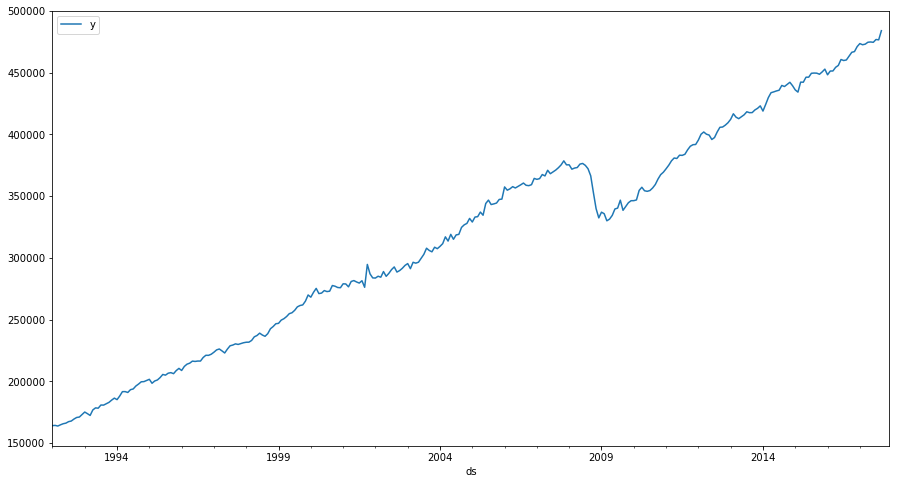

In [4]:
%matplotlib inline
df1.set_index('ds').plot(figsize=(15,8))

In [5]:
df2 = pd.melt(df_seasonal, id_vars=['YEAR'], value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'], var_name='MONTH')
df2['ds'] = pd.to_datetime(df2['YEAR'].astype(str) + df2['MONTH'], format='%Y%b')
df2 = df2.drop('YEAR', axis=1)
df2 = df2.drop('MONTH', axis=1)
df2.columns = ['factor', 'ds']
df2 = df2[['ds', 'factor']]
df2 = df2.sort_values(['ds'], ascending=True)
df2 = df2.reset_index(drop=True)
df2.head()

,ds,factor
0,1992-01-01,0.897
1,1992-02-01,0.895
2,1992-03-01,0.975
3,1992-04-01,0.993
4,1992-05-01,1.027


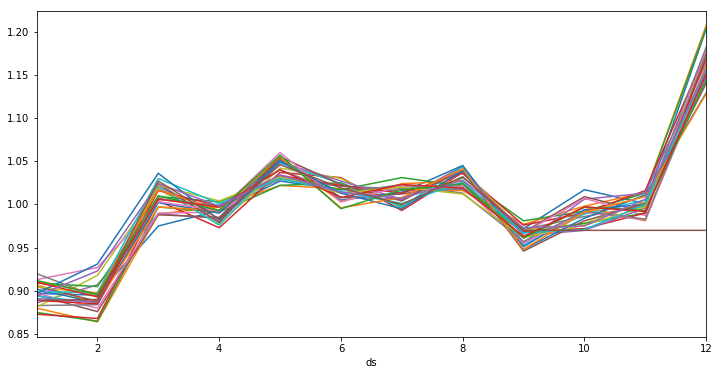

In [6]:
d3 = pd.DataFrame(df2, columns=['ds', 'factor']).set_index('ds')
d3.index = [d3.index.month, d3.index.year]
d3 = d3.factor.unstack().interpolate()
plot = d3.plot(legend=0, figsize=(12,6))

In [7]:
df = pd.DataFrame(df1[['ds']], index=df1.index, columns=['ds'])
df['y'] = df1['y'] * df2['factor']
df.head()

,ds,y
0,1992-01-01,147182.451
1,1992-02-01,147012.700
2,1992-03-01,159653.325
3,1992-04-01,163605.687
4,1992-05-01,170088.659


In [8]:
df.y = np.log(df.y)
ts = df.copy()
ts_validate = df.copy()

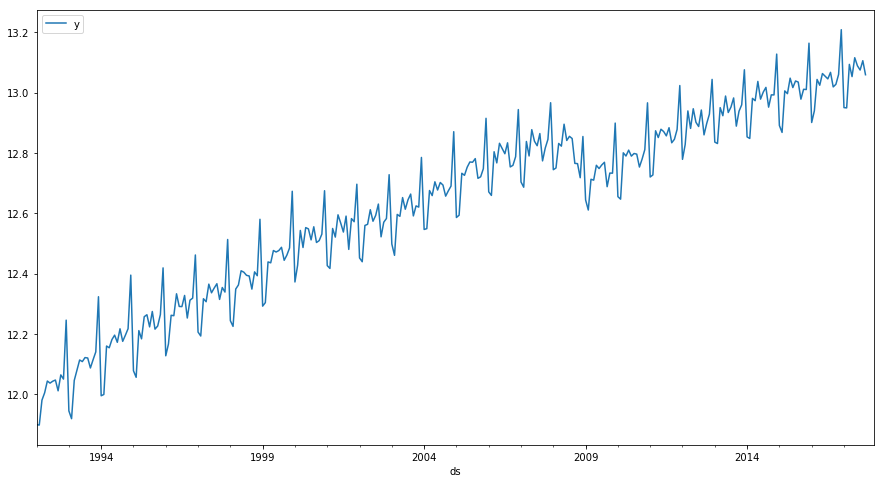

In [9]:
ts.set_index('ds').plot(figsize=(15,8))

In [10]:
ts_train = ts[(ts.ds < '2016-01-01') & (ts.ds > '2008-12-01')]

In [11]:
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet

model = Prophet()
model.fit(ts_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = model.make_future_dataframe(periods=22, freq='MS')
forecast = model.predict(future)

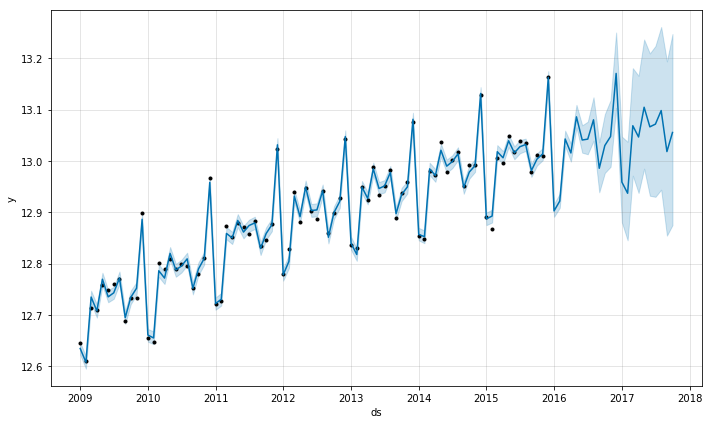

In [13]:
plot = model.plot(forecast)

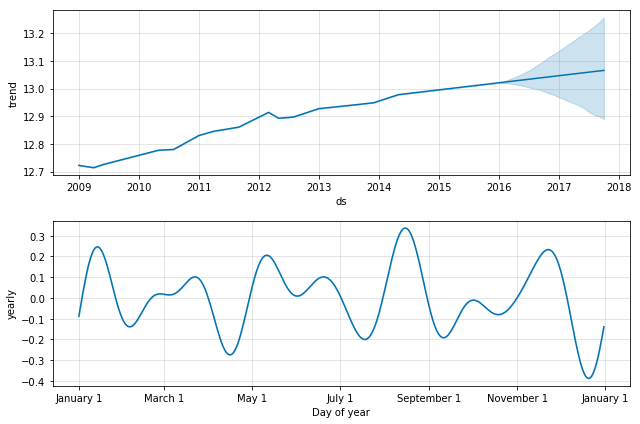

In [14]:
plot = model.plot_components(forecast)

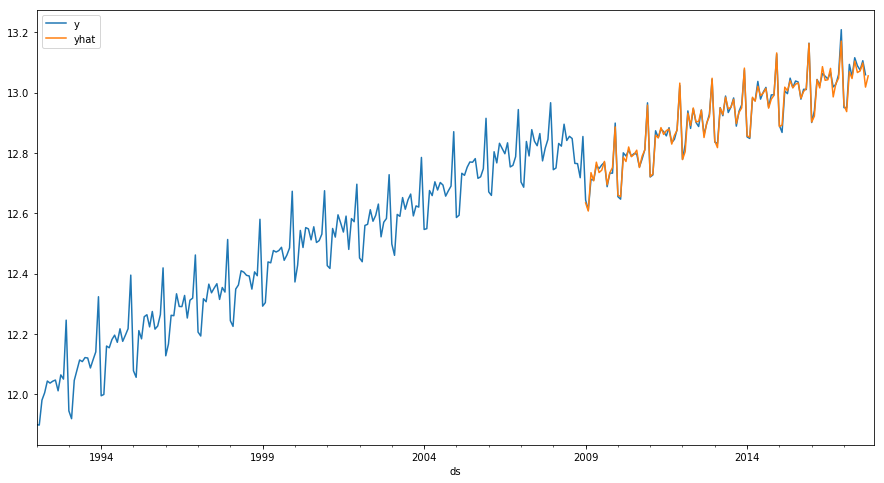

In [15]:
df_visualise = pd.merge(ts_validate, forecast, left_on='ds', right_on='ds', how='outer')
df_visualise = df_visualise.set_index('ds')
df_visualise[['y', 'yhat']].plot(figsize=(15,8),)

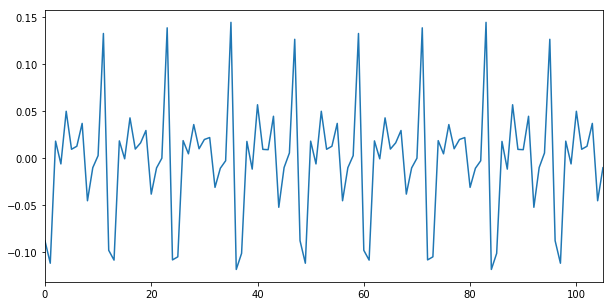

In [16]:
forecast[('seasonalities')].plot(figsize=(10,5))

In [17]:
forecast.columns

Index(['ds', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower', 'yhat_upper',
       'seasonal', 'seasonal_lower', 'seasonal_upper', 'seasonalities',
       'seasonalities_lower', 'seasonalities_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'yhat'],
      dtype='object')